In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap, shiftgrid, addcyclic
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy import stats
import nc_time_axis
import cmocean
import cartopy.crs as ccrs
from scipy.stats import ks_2samp
import cftime
from matplotlib.colors import TwoSlopeNorm
import matplotlib.dates as mdates
from dask.distributed import Client
from matplotlib.ticker import FormatStrFormatter
import re
from itertools import groupby
import zarr

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 1.11 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35545,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 1.11 TiB
Comm: tcp://127.0.0.1:36795,Total threads: 7
Dashboard: http://127.0.0.1:42035/status,Memory: 141.72 GiB
Nanny: tcp://127.0.0.1:44329,


2025-02-28 10:39:21,712 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:36961' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {'original-open_dataset-Q-88e04a6cc6a3d4706bc7904d81b5e1dd', 'original-open_dataset-Q-b1c388a6bc75b929eb6aaeabb0898853'} (stimulus_id='handle-worker-cleanup-1740735561.712068')
2025-02-28 10:39:21,726 - distributed.nanny - WARNING - Restarting worker


In [4]:
# set default fontsize for Plots
plt.rcParams.update({"font.size": 22})
xr.set_options(keep_attrs=True)

In [5]:
### Load CMAM
#select model name
model = "CMAM"
#chose infilepath
infile_path = Path(f"/sto0/data/Intermediate/Hunga_Tonga_byAles/htmip/htmip/Exp1_fixedSST/{model}")

#select target variable 
what = "h2o"
#select infiles with and without HTHH
infiles_w = sorted(infile_path.glob(f"{what}*H2Oonly*.nc"))
infiles_wo = sorted(infile_path.glob(f"{what}*NoVolc*.nc"))

#Open datasets for with and without
cmam_w = xr.open_mfdataset(
    infiles_w[:],
    parallel=True,
    combine="nested",
    concat_dim=["ens"])#.pipe(process_sat)

cmam_wo = xr.open_mfdataset(
    infiles_wo[:],
    parallel=True,
    combine="nested",
    concat_dim=["ens"])#.pipe(process_sat)



In [6]:
### Load WACCM fixed SST
#select model name
model = "waccm6mam"
infile_path = Path(f"/sto0/data/Intermediate/Hunga_Tonga_byAles/htmip/htmip/Exp1_fixedSST/{model}")

# select variable name
what = "hus"
infiles_w = sorted(infile_path.glob(f"*SO2andH2O*{what}.nc"))
infiles_wo = sorted(infile_path.glob(f"*NoVolc*{what}.nc"))

# load datasets with and without HTHH
waccm_w = xr.open_mfdataset(
    infiles_w[:],
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"])#.pipe(process_sat)

waccm_wo = xr.open_mfdataset(
    infiles_wo[:],
    parallel=True,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"])#.pipe(process_sat)

In [7]:
# LOAD MIROC

model = "MIROC-CHASER"
infile_path = Path(f"/sto0/data/Intermediate/Hunga_Tonga_byAles/htmip/htmip/Exp1_fixedSST/{model}")

infiles_wo = sorted(infile_path.glob('*h2o_*NoVolc*.ensemble*.nc'))
infiles_w = sorted(infile_path.glob('*h2o_*SO2andH2O*.ensemble*.nc'))


# Open and concatenate NetCDF files along 'ens' dimension
miroc_w = xr.concat(
    [xr.open_mfdataset(list(files), combine="by_coords", parallel=False) for _, files in groupby(infiles_w, key=lambda f: re.search(r'ensemble(\d+)', str(f)).group(1))],
    dim="ens"
)#.pipe(process_sat)

miroc_wo = xr.concat(
    [xr.open_mfdataset(list(files), combine="by_coords", parallel=False) for _, files in groupby(infiles_wo, key=lambda f: re.search(r'ensemble(\d+)', str(f)).group(1))],
    dim="ens"
)#.pipe(process_sat)

In [8]:
infile_path = Path(f"/sto0/data/Intermediate/Hunga_Tonga_byAles/htmip/htmip/Exp1and4_coupledocean/waccm6mam-45plevels")

what = "h2o"
infiles_w = sorted(infile_path.glob(f"*SO2andH2O*{what}.nc"))
infiles_wo = sorted(infile_path.glob(f"*NoVolc*{what}.nc"))


waccm2_wo = xr.open_mfdataset(
    infiles_wo[:],
    parallel=False,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"],
)#.pipe(process_sat)

waccm2_w = xr.open_mfdataset(
    infiles_w[:],
    parallel=False,  #  will be performed in parallel using dask.delayed
    combine="nested",
    concat_dim=["ens"],
)#.pipe(process_sat)

In [9]:
geos_wo = xr.open_zarr('/sto0/data/Intermediate/Hunga_Tonga_byAles/htmip/htmip/Exp1_fixedSST/GEOSCCM/h2o_ppmv_ctrl.zarr/')
geos_w = xr.open_zarr('/sto0/data/Intermediate/Hunga_Tonga_byAles/htmip/htmip/Exp1_fixedSST/GEOSCCM/h2o_ppmv_prtb.zarr/')

In [10]:
waccm_w = waccm_w.rename({"level": "plev"})
miroc_w = miroc_w.rename({"CMIP6P39": "plev"})
cmam_w = cmam_w.rename({"plev": "plev"})
waccm2_w = waccm2_w.rename({"level": "plev"})
geos_w = geos_w.rename({"lev": "plev"})

waccm_wo = waccm_wo.rename({"level": "plev"})
miroc_wo = miroc_wo.rename({"CMIP6P39": "plev"})
cmam_wo = cmam_wo.rename({"plev": "plev"})
waccm2_wo = waccm2_wo.rename({"level": "plev"})
geos_wo= geos_wo.rename({"lev": "plev"})

In [11]:
datasets = {"CMAM": [cmam_w, cmam_wo], 
            "MIROC-CHASER": [miroc_w, miroc_wo], 
            "GEOSCCM": [geos_w, geos_wo], 
            "WACCM": [waccm_w, waccm_wo], 
            "WACCM coupled ocean": [waccm2_w, waccm2_wo]}

for model in datasets.keys():
    data_1 = datasets[model][0]  # Select first dataset
    data_2 = datasets[model][1]  # Select second dataset

    # Only rename if "plev" does NOT exist
    if "plev" not in data_1.dims:
        for dim in list(data_1.dims):  # Iterate over dimension names
            if dim in ["level", "lev", "CMIP6P39"]:  # Check if it matches
                data_1 = data_1.rename({dim: "plev"})  # Rename dimension
                data_2 = data_2.rename({dim: "plev"})



In [12]:
mass_air = 28.9647
mass_h2o = 18.0153

waccm_w["h2o_ppmv"] = waccm_w["Q"] * mass_air/mass_h2o*1e6
waccm_wo["h2o_ppmv"] = waccm_wo["Q"] * mass_air/mass_h2o*1e6


In [13]:
cmam_w["h2o_ppmv"] = cmam_w["h2o"] * 1e6
cmam_wo["h2o_ppmv"] = cmam_wo["h2o"] * 1e6

miroc_w["h2o_ppmv"] = miroc_w["Q"] * 1e6
miroc_wo["h2o_ppmv"] = miroc_wo["Q"] * 1e6

waccm2_w["h2o_ppmv"] = waccm2_w["H2O"] * 1e6
waccm2_wo["h2o_ppmv"] = waccm2_wo["H2O"] * 1e6

In [14]:
cmam_w["plev"] = cmam_w["plev"] / 100
cmam_w["plev"].attrs['units'] = 'hPa'
cmam_wo["plev"] = cmam_wo["plev"] / 100
cmam_wo["plev"].attrs['units'] = 'hPa'

cmam_w["time"] = pd.date_range("2022-02-01", freq='1ME', periods=cmam_w.time.shape[0])
cmam_wo["time"] = pd.date_range("2022-02-01", freq='1ME', periods=cmam_wo.time.shape[0])

miroc_w["time"] = pd.date_range("2022-02-01", freq='1ME', periods=miroc_w.time.shape[0])
miroc_wo["time"] = pd.date_range("2022-02-01", freq='1ME', periods=miroc_wo.time.shape[0])

geos_w["time"] = pd.date_range("2022-02-01", freq='1ME', periods=geos_w.time.shape[0])
geos_wo["time"] = pd.date_range("2022-02-01", freq='1ME', periods=geos_wo.time.shape[0])

waccm_w["time"] = pd.date_range("2022-02-01", freq='1ME', periods=waccm_w.time.shape[0])
waccm_wo["time"] = pd.date_range("2022-02-01", freq='1ME', periods=waccm_wo.time.shape[0])

waccm2_w["time"] = pd.date_range("2022-02-01", freq='1ME', periods=waccm2_w.time.shape[0])
waccm2_wo["time"] = pd.date_range("2022-02-01", freq='1ME', periods=waccm2_wo.time.shape[0])

In [15]:
sel_dict = dict(time = slice('2022-01','2031-12'))

weights_cmam = np.cos(np.deg2rad(cmam_w.h2o_ppmv.lat))
weights_cmam.name = "weights"
cmam_w_gm = cmam_w.h2o_ppmv.sel(**sel_dict).weighted(weights_cmam).mean(['lat','lon']).load()
cmam_wo_gm = cmam_wo.h2o_ppmv.sel(**sel_dict).weighted(weights_cmam).mean(['lat','lon']).load()

weights_miroc = np.cos(np.deg2rad(miroc_w.h2o_ppmv.lat))
weights_miroc.name = "weights"
miroc_w_gm = miroc_w.h2o_ppmv.sel(**sel_dict).weighted(weights_miroc).mean(['lat','lon']).load()
miroc_wo_gm = miroc_wo.h2o_ppmv.sel(**sel_dict).weighted(weights_miroc).mean(['lat','lon']).load()

weights_waccm = np.cos(np.deg2rad(waccm_w.h2o_ppmv.lat))
weights_waccm.name = "weights"
waccm_w_gm = waccm_w.h2o_ppmv.sel(**sel_dict).weighted(weights_waccm).mean(['lat','lon']).load()
waccm_wo_gm = waccm_wo.h2o_ppmv.sel(**sel_dict).weighted(weights_waccm).mean(['lat','lon']).load()


weights_geos = np.cos(np.deg2rad(geos_w.h2o_ppmv.lat))
weights_geos.name = "weights"
geos_w_gm = geos_w.h2o_ppmv.sel(**sel_dict).weighted(weights_geos).mean(['lat','lon']).load()
geos_wo_gm = geos_wo.h2o_ppmv.sel(**sel_dict).weighted(weights_geos).mean(['lat','lon']).load()

weights_waccm2 = np.cos(np.deg2rad(waccm2_w.h2o_ppmv.lat))
weights_waccm2.name = "weights"
waccm2_w_gm = waccm2_w.h2o_ppmv.sel(**sel_dict).weighted(weights_waccm2).mean(['lat','lon']).load()
waccm2_wo_gm = waccm2_wo.h2o_ppmv.sel(**sel_dict).weighted(weights_waccm2).mean(['lat','lon']).load()


In [16]:
cmam_anom_gm = cmam_w_gm.mean("ens") - cmam_wo_gm.mean("ens")
cmam_anom_gm = cmam_w_gm.mean("ens") - cmam_wo_gm.mean("ens")

miroc_anom_gm = miroc_w_gm.mean("ens") - miroc_wo_gm.mean("ens")
miroc_anom_gm = miroc_w_gm.mean("ens") - miroc_wo_gm.mean("ens")

geos_anom_gm = geos_w_gm.mean("ens") - geos_wo_gm.mean("ens")
geos_anom_gm = geos_w_gm.mean("ens") - geos_wo_gm.mean("ens")

waccm_anom_gm = waccm_w_gm.mean("ens") - waccm_wo_gm.mean("ens")
waccm_anom_gm = waccm_w_gm.mean("ens") - waccm_wo_gm.mean("ens")

waccm2_anom_gm = waccm2_w_gm.mean("ens") - waccm2_wo_gm.mean("ens")
waccm2_anom_gm = waccm2_w_gm.mean("ens") - waccm2_wo_gm.mean("ens")

datasets = {"CMAM": [cmam_w_gm, cmam_wo_gm, cmam_anom_gm], "MIROC-CHASER": [miroc_w_gm, miroc_wo_gm, miroc_anom_gm], "GEOSCCM": [geos_w_gm, geos_wo_gm, geos_anom_gm], "WACCM": [waccm_w_gm, waccm_wo_gm, waccm_anom_gm], "WACCM coupled ocean": [waccm2_w_gm, waccm2_wo_gm, waccm2_anom_gm]}

In [17]:
vmin = 0.9 * min([miroc_anom_gm.sel(plev = slice(100, 0.1)).min(), cmam_anom_gm.sel(plev = slice(100, 0.1)).min(), geos_anom_gm.sel(plev = slice(100, 0.1)).min(), waccm_anom_gm.sel(plev = slice(100, 0.1)).min(), waccm2_anom_gm.sel(plev = slice(100, 0.1)).min()]).values
vmax = 0.9 * max([miroc_anom_gm.sel(plev = slice(100, 0.1)).max(), cmam_anom_gm.sel(plev = slice(100, 0.1)).max(), geos_anom_gm.sel(plev = slice(100, 0.1)).min(), waccm_anom_gm.sel(plev = slice(100, 0.1)).max(), waccm2_anom_gm.sel(plev = slice(100, 0.1)).max()]).values

if abs(vmin) < abs(vmax):
    vmin = -vmax
else:
    vmax = abs(vmin)

divnorm = TwoSlopeNorm(vmin= -2, vcenter=0, vmax= 2)

In [18]:
diffs = {"CMAM": cmam_anom_gm, "MIROC-CHASER": miroc_anom_gm,"GEOSCCM": geos_anom_gm, "WACCM": waccm_anom_gm, "WACCM coupled ocean": waccm2_anom_gm}
for model in diffs.keys():
    diffs[model] = diffs[model].sel(plev = slice(100, 0.1))

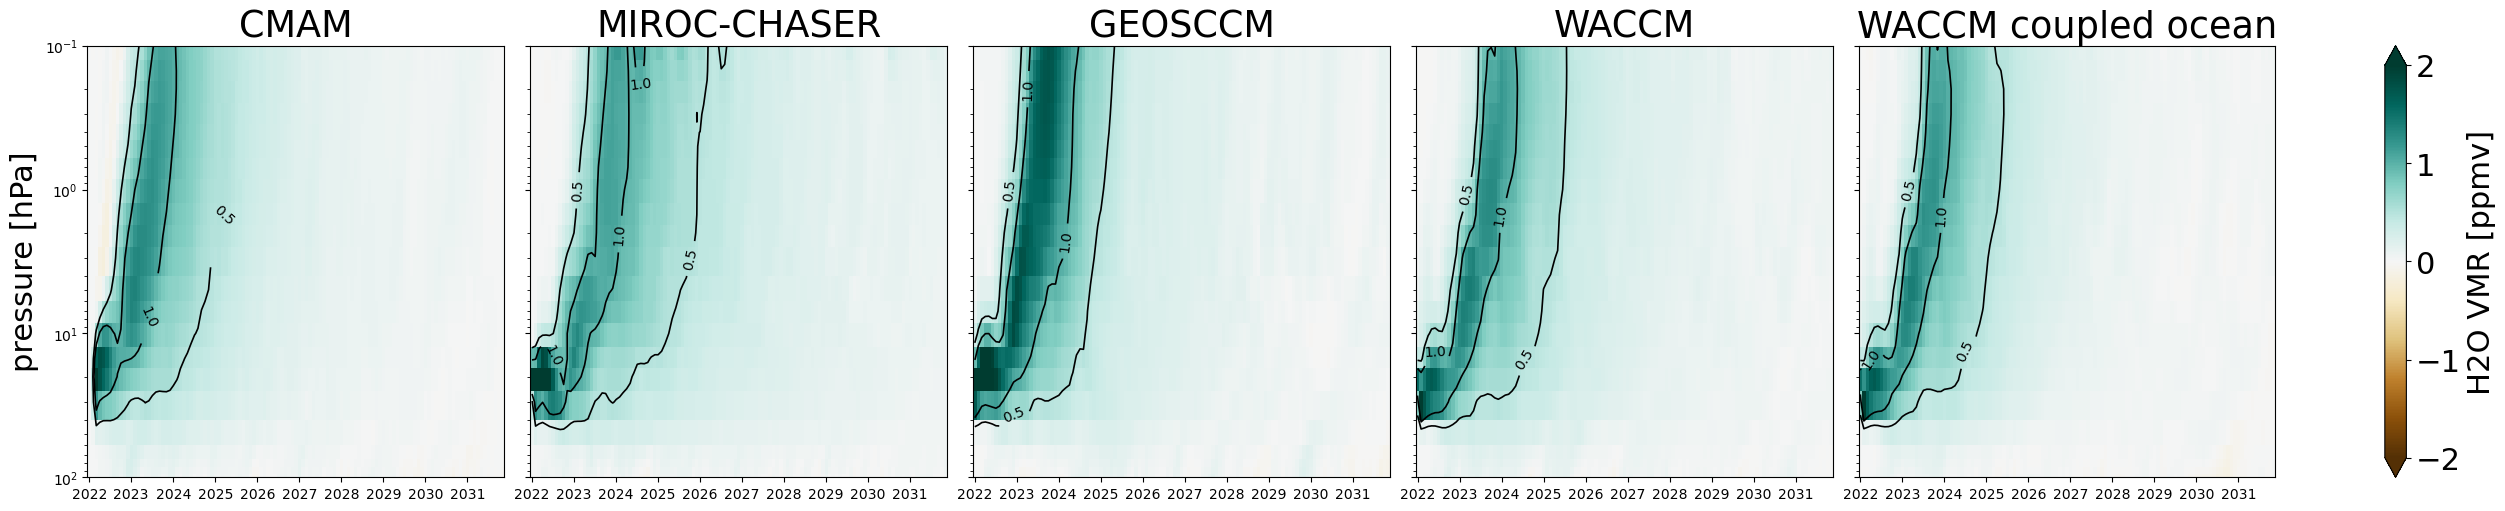

In [20]:
# create list with every year
xticks = list(cmam_anom_gm["time"].values[::12])

# create Subplot 1x5 grid, 
fig, axs = plt.subplots(1, 5, figsize=(25, 5), constrained_layout = True, sharex = True, sharey = True)
axs = axs.flatten()

# Loop over each season and corresponding axis
for ax, model in zip(axs, diffs):
    # Extract data for each model
    data = diffs[model]
    data["time"] = pd.date_range("2022-02-01", freq='1ME', periods=data.time.shape[0])
    # Create the pcolormesh plot
    plot = ax.pcolormesh(
        data["time"],
        data["plev"],
        data.values.T,
        cmap="BrBG",
        norm = divnorm,
    )
    contour_levels = [0.5, 1]
    contours = ax.contour(
        data["time"],
        data["plev"],
        data.values.T,
        levels = contour_levels,
        colors = "black",
        linewidths = 1.2
    )

    ax.clabel(contours, fmt = "%.1f", inline = True, fontsize = 10)

    # set title and costumize xticks
    ax.set_title(f"{model}")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xticks(xticks)               
    ax.set_yscale('log')
    ax.set_ylim(100, 0.1)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

    
# Add one colorbar
fig.colorbar(plot,
             ax=axs,
             orientation="vertical",
             fraction=0.05,
             pad=0.05,
             label="H2O VMR [ppmv]",
            extend = "both")
axs[0,].set_ylabel("pressure [hPa]")

#plt.savefig(fname = "h2o_anom_gm_w_cont")
plt.show()
plt.close(fig)

In [21]:
cmam_anom_zm = cmam_w.h2o_ppmv.mean("lon").mean("ens") - cmam_wo.h2o_ppmv.mean("lon").mean("ens")
miroc_anom_zm = miroc_w.h2o_ppmv.mean("lon").mean("ens") - miroc_wo.h2o_ppmv.mean("lon").mean("ens")
geos_anom_zm = geos_w.h2o_ppmv.mean("lon").mean("ens") - geos_wo.h2o_ppmv.mean("lon").mean("ens")
waccm_anom_zm = waccm_w.h2o_ppmv.mean("lon").mean("ens") - waccm_wo.h2o_ppmv.mean("lon").mean("ens")
waccm2_anom_zm = waccm2_w.h2o_ppmv.mean("lon").mean("ens") - waccm2_wo.h2o_ppmv.mean("lon").mean("ens")

In [22]:


sel_time = dict(time = slice("2022", "2024"))


In [23]:
max_idx = {}
for model in diffs.keys():
    max_idx[model] = diffs[model].sel(plev = slice(100, 0.1)).idxmax('plev')

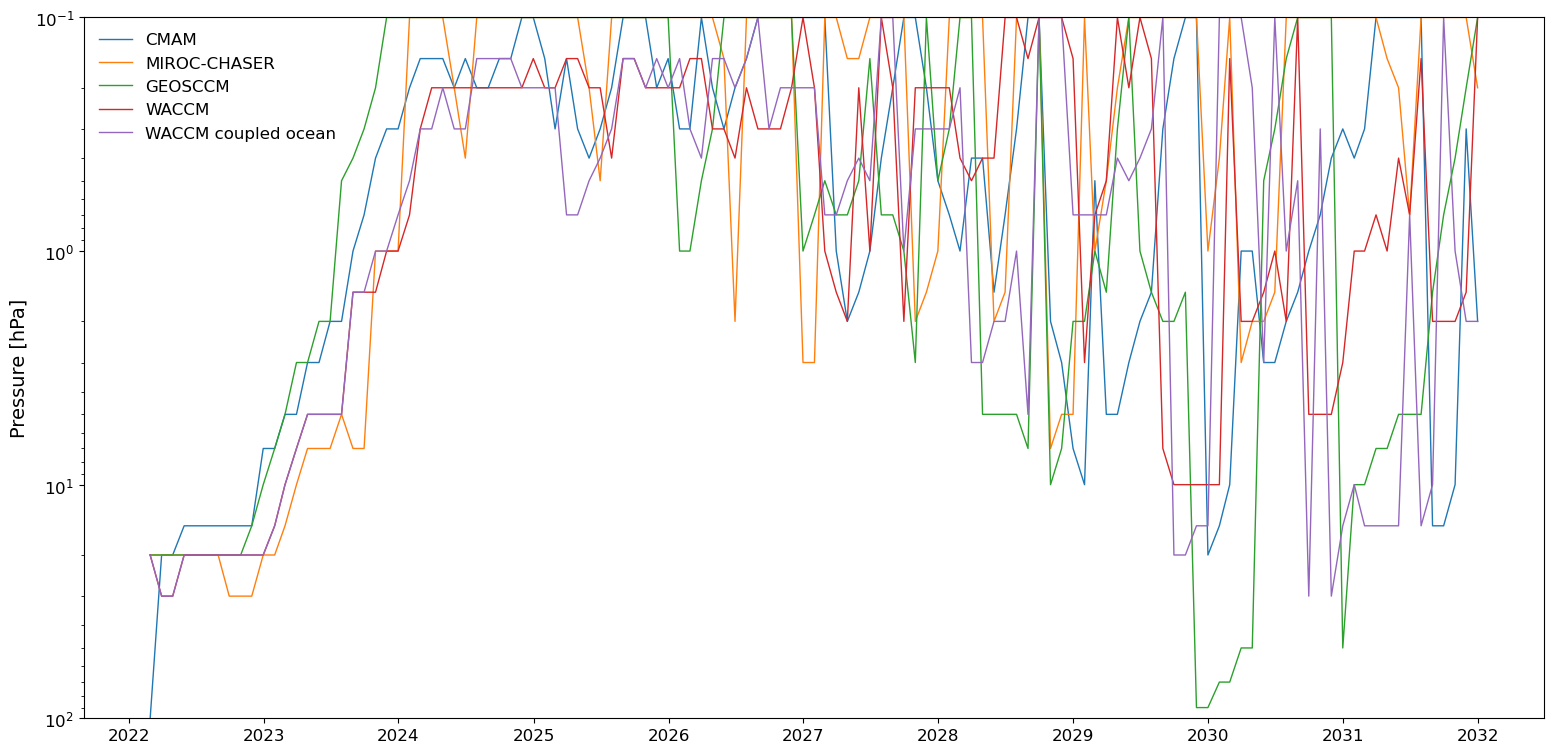

In [24]:
# Use a scientific-friendly color palette
colors = sns.color_palette("viridis", len(max_idx))  # More muted and professional colors

# Create figure
plt.figure(figsize=(16, 8))

# Loop over all models in max_idx dictionary with improved styling
for (model, max_plev), color in zip(max_idx.items(), colors):
    # Convert CFTime to Pandas DateTime format
    max_plev["time"] = pd.date_range("2022-02-01", freq='1ME', periods=max_plev.time.shape[0])

    # Plot each model's data with a slightly thicker line
    plt.plot(max_plev["time"], max_plev, linestyle='-', label=model, linewidth=1)

# Improve plot readability
plt.yscale("log")  # Logarithmic scale for pressure
plt.gca().invert_yaxis()  # Invert y-axis since pressure decreases with altitude
plt.ylabel("Pressure [hPa]", fontsize=14)
plt.ylim(100, 0.1)
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)

# Improved legend placement outside the plot for clarity
plt.legend(fontsize=12, title_fontsize=12, loc='upper left', frameon = False)

# Adjust layout to fit everything nicely
plt.tight_layout()

# Show the plot
plt.savefig(fname = "Max_SWV.png")
plt.show()
plt.close()


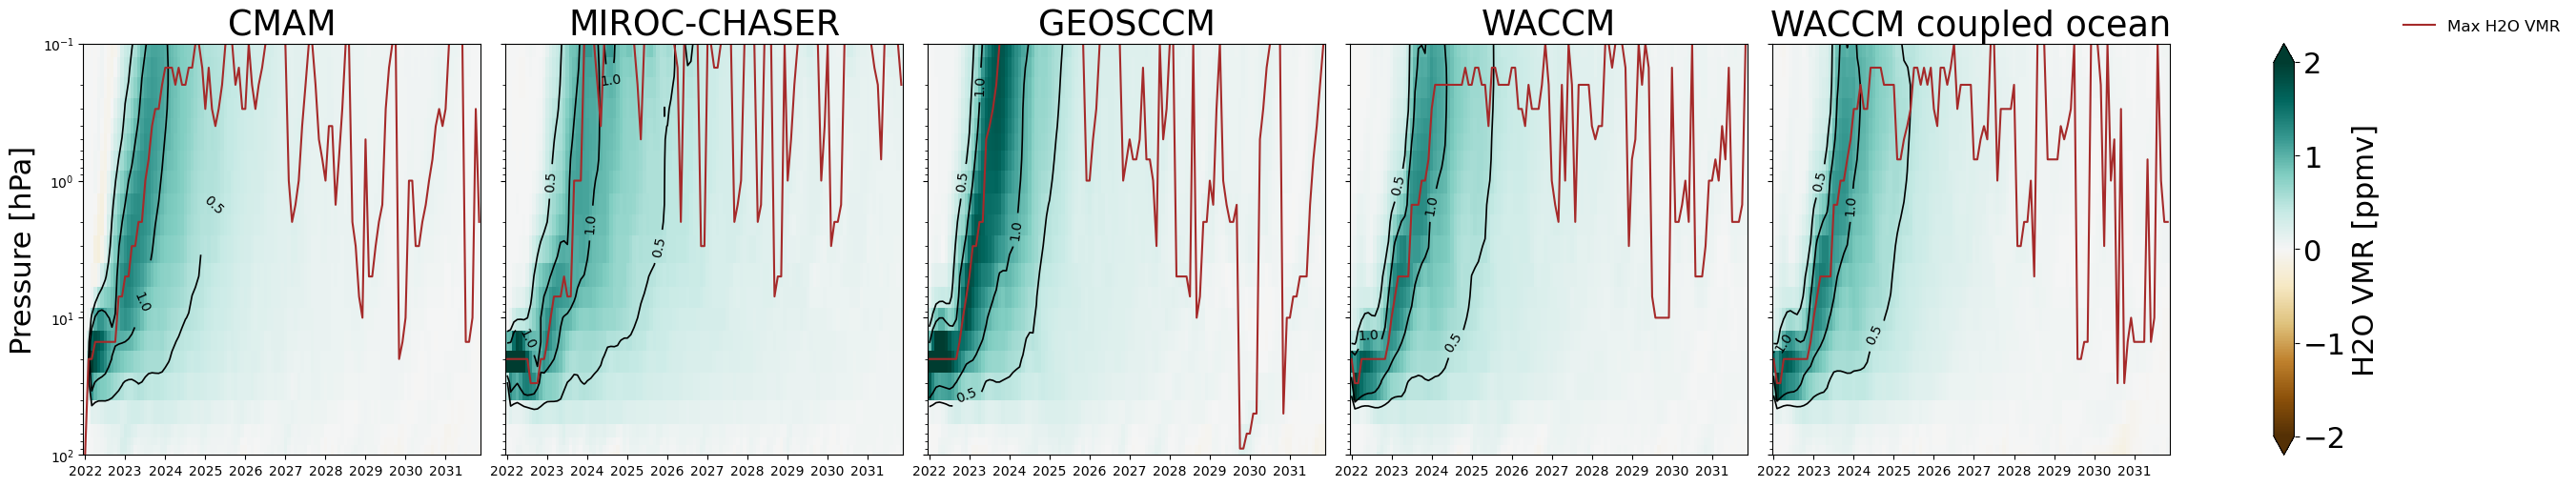

In [25]:
# Create list with every year
xticks = list(cmam_anom_gm["time"].values[::12])

# Create subplot grid 1x5
fig, axs = plt.subplots(1, 5, figsize=(25, 5), constrained_layout=True, sharex=True, sharey=True)
axs = axs.flatten()

# Use a scientific-friendly color palette for max lines
colors = sns.color_palette("viridis", len(max_idx))  

# Loop over each model for pcolormesh + max line overlay
for ax, model, color in zip(axs, diffs, colors):

    # Extract the data for each model
    data = diffs[model]
    data["time"] = pd.date_range("2022-02-01", freq='1ME', periods=data.time.shape[0])

    # Create the pcolormesh plot
    plot = ax.pcolormesh(
        data["time"],
        data["plev"],
        data.values.T,
        cmap="BrBG",
        norm=divnorm,
    )

    # Add contour lines for specific values
    contour_levels = [0.5, 1]
    contours = ax.contour(
        data["time"],
        data["plev"],
        data.values.T,
        levels=contour_levels,
        colors="black",
        linewidths=1.2
    )
    ax.clabel(contours, fmt="%.1f", inline=True, fontsize=10)

    # Overlay max line plot for each model
    if model in max_idx:
        max_plev = max_idx[model]
        max_plev["time"] = pd.date_range("2022-02-01", freq='1ME', periods=max_plev.time.shape[0])
        ax.plot(max_plev["time"], max_plev, linestyle='-', linewidth=1.5, color="brown", label="Max H2O VMR")

    # Set title and customize xticks
    ax.set_title(f"{model}")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xticks(xticks)
    ax.set_yscale('log')
    ax.set_ylim(100, 0.1)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

# Add one colorbar
fig.colorbar(plot,
             ax=axs,
             orientation="vertical",
             fraction=0.05,
             pad=0.05,
             label="H2O VMR [ppmv]",
             extend="both")

axs[0].set_ylabel("Pressure [hPa]")

# Add a single legend outside the plot for the max lines
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(1, 1), fontsize=12, frameon=False)

# Save and display the figure
plt.savefig(fname="h2o_anom_gm_with_max.png", bbox_inches="tight")
plt.show()
plt.close(fig)
